# SVM Implementation

I did separate preprocessing/loading from the preprocessing.ipynb because I was already working on this before preprocessing was done.

In [ ]:
import pandas as pd
import itertools
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE, ADASYN

df = pd.read_csv("loan_approval_dataset.csv")
df.drop(columns=["Id"], inplace=True)
df["Risk_Flag"] = df["Risk_Flag"].apply(lambda x: 1 if x == 1 else -1)

X = df.drop(columns=["Risk_Flag"])
y = df["Risk_Flag"]

X = pd.get_dummies(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=9, stratify=y
)

### Simple Test to see that SVM training is working.

In [2]:
linear_svm = SVC(kernel="linear", class_weight="balanced", random_state=9, max_iter=250, verbose=True)

linear_svm.fit(X_train, y_train)

y_pred = linear_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

[LibSVM]

c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.2421
Confusion Matrix:
[[ 6791 37410]
 [  787  5412]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.15      0.26     44201
           1       0.13      0.87      0.22      6199

    accuracy                           0.24     50400
   macro avg       0.51      0.51      0.24     50400
weighted avg       0.80      0.24      0.26     50400



Before I got to these behemoth parameter grids, I was not being organized and ran a bunch of training loops for a bunch of hyperparams. I ended up deleting the results and just going with one big iteration that I am going to take as the final hyperparameter testing results.

I have tested different max_iters values and it did not seem to effect the results.

In [4]:
customClassWeight1 = {1: 3, -1: 1}
customClassWeight2 = {1: 2, -1: 1}
class_weight_options = ["balanced", customClassWeight1, customClassWeight2]

max_iters = [250]
linear_params = {
    "kernel": ["linear"],
    "C": [0.1, 1, 10, 100],
    "class_weight": class_weight_options
}
rbf_params = {
    "kernel": ["rbf"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 5, 10, 100],
    "class_weight": class_weight_options
}
poly_params = {
    "kernel": ["poly"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 5, 10, 100],
    "degree": [2, 3, 4],
    "class_weight": class_weight_options
}

In [ ]:
# For max iter in max iters, train linear, poly, and rbf svms
for max_iter_value in max_iters:

    # Linear
    results_linear = []
    linear_keys = list(linear_params.keys())
    linear_values = list(linear_params.values())
    for combo in itertools.product(*linear_values):
        params = dict(zip(linear_keys, combo))
        params["max_iter"] = max_iter_value
        
        # Train
        model = SVC(random_state=9, verbose=False, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report_text = classification_report(y_test, y_pred, zero_division=0)
        
        # Results
        results_linear.append({
            "kernel": params["kernel"],
            "C": params["C"],
            "gamma": None,
            "degree": None,
            "class_weight": params["class_weight"],
            "max_iter": max_iter_value,
            "accuracy": acc,
            "classification_report": report_text
        })
        
        # Print results
        print(f"[Linear] max_iter: {max_iter_value}, C: {params['C']}, class_weight: {params['class_weight']} -> accuracy: {acc:.4f}")
        print(report_text)
    
    # Write results
    df_linear = pd.DataFrame(results_linear)
    linear_csv_filename = f"linear_report.csv"
    df_linear.to_csv(linear_csv_filename, index=False)
    print(f"Saved linear report to {linear_csv_filename}\n")
    
    # RBF
    results_rbf = []
    rbf_keys = list(rbf_params.keys())
    rbf_values = list(rbf_params.values())
    for combo in itertools.product(*rbf_values):
        params = dict(zip(rbf_keys, combo))
        params["max_iter"] = max_iter_value

        # Train
        model = SVC(random_state=9, verbose=False, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report_text = classification_report(y_test, y_pred, zero_division=0)

        # Results
        results_rbf.append({
            "kernel": params["kernel"],
            "C": params["C"],
            "gamma": params["gamma"],
            "degree": None,  # Not applicable for RBF
            "class_weight": params["class_weight"],
            "max_iter": max_iter_value,
            "accuracy": acc,
            "classification_report": report_text
        })

        # Print results
        print(f"[RBF] max_iter: {max_iter_value}, C: {params['C']}, gamma: {params['gamma']}, class_weight: {params['class_weight']} -> accuracy: {acc:.4f}")
        print(report_text)
    
    # Write results
    df_rbf = pd.DataFrame(results_rbf)
    rbf_csv_filename = f"rbf_report.csv"
    df_rbf.to_csv(rbf_csv_filename, index=False)
    print(f"Saved RBF report to {rbf_csv_filename}\n")
    
    # Polynomial
    results_poly = []
    poly_keys = list(poly_params.keys())
    poly_values = list(poly_params.values())
    for combo in itertools.product(*poly_values):
        params = dict(zip(poly_keys, combo))
        params["max_iter"] = max_iter_value
        
        # Train
        model = SVC(random_state=9, verbose=False, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report_text = classification_report(y_test, y_pred, zero_division=0)
        
        # Results
        results_poly.append({
            "kernel": params["kernel"],
            "C": params["C"],
            "gamma": params["gamma"],
            "degree": params["degree"],
            "class_weight": params["class_weight"],
            "max_iter": max_iter_value,
            "accuracy": acc,
            "classification_report": report_text
        })
        
        # Print results
        print(f"[Poly] max_iter: {max_iter_value}, C: {params['C']}, gamma: {params['gamma']}, degree: {params['degree']}, class_weight: {params['class_weight']} -> accuracy: {acc:.4f}")
        print(report_text)
    
    # Write results
    df_poly = pd.DataFrame(results_poly)
    poly_csv_filename = f"poly_report.csv"
    df_poly.to_csv(poly_csv_filename, index=False)
    print(f"Saved poly report to {poly_csv_filename}\n")

c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[Linear] max_iter: 250, C: 0.1, class_weight: balanced -> accuracy: 0.2865
              precision    recall  f1-score   support

          -1       0.89      0.21      0.34     44201
           1       0.13      0.82      0.22      6199

    accuracy                           0.29     50400
   macro avg       0.51      0.51      0.28     50400
weighted avg       0.80      0.29      0.33     50400



### Parser Logic


In [ ]:
# Get precision and recall scores
def parsePrecisionAndRecall(report, label):
    match = re.search(rf"^\s*{label}\s+([\d.]+)\s+([\d.]+)", report, re.MULTILINE)
    if match:
        precision, recall = float(match.group(1)), float(match.group(2))
        return precision, recall
    return 0.0, 0.0

# Create new csvs with results that are actually worth evaluating
def filterResults(filename, output_filename):
    df = pd.read_csv(filename)
    keep_rows = []

    for _, row in df.iterrows():
        acc = float(row["accuracy"])
        if acc < 0.13 or acc > 0.87:
            continue

        report = row["classification_report"]

        precNeg, recNeg = parsePrecisionAndRecall(report, "-1")
        precPos, recPos = parsePrecisionAndRecall(report, "1")

        if (precNeg < 0.10 or recNeg < 0.10 or
            precPos < 0.10 or recPos < 0.10):
            continue

        keep_rows.append(row)

    filtered_df = pd.DataFrame(keep_rows)
    filtered_df.to_csv(output_filename, index=False)
    print(f"Filtered report saved to {output_filename} with {len(filtered_df)} rows")

filterResults("linear_report.csv", "filtered_linear_report.csv")
filterResults("rbf_report.csv", "filtered_rbf_report.csv")
filterResults("poly_report.csv", "filtered_poly_report.csv")
# Moved these files to ../Results to not interfere with switching branches in git

### Read in filtered results and try other tests

In [10]:
# If balanced return balanced. If not, return dict
def parseClassWeight(cw):
    if cw.strip() == "balanced":
        return "balanced"
    else:
        return eval(cw)

In [ ]:
filtered_files = {
    "linear": "../Results/filtered_linear_report.csv",
    "rbf": "../Results/filtered_rbf_report.csv",
    "poly": "../Results/filtered_poly_report.csv"
}
chosen_params = {}

# Read in filtered csvs
for kernel, filename in filtered_files.items():
    df_hp = pd.read_csv(filename)

    random_row = df_hp.sample(1).iloc[0]

    params = {
        "kernel": random_row["kernel"],
        "C": random_row["C"],
        "max_iter": int(random_row["max_iter"]),
        "class_weight": parseClassWeight(random_row["class_weight"])
    }
    if "gamma" in random_row and pd.notnull(random_row["gamma"]) and str(random_row["gamma"]).lower() != "none":
        params["gamma"] = random_row["gamma"]
    if "degree" in random_row and pd.notnull(random_row["degree"]) and str(random_row["degree"]).lower() != "none":
        params["degree"] = int(random_row["degree"])

    chosen_params[kernel] = params

    print(f"Chosen hyperparameters for {kernel} kernel: {params}")

Chosen hyperparameters for linear kernel: {'kernel': 'linear', 'C': np.float64(100.0), 'max_iter': 250, 'class_weight': 'balanced'}
Chosen hyperparameters for rbf kernel: {'kernel': 'rbf', 'C': np.float64(100.0), 'max_iter': 250, 'class_weight': {1: 3, -1: 1}, 'gamma': np.float64(0.001)}
Chosen hyperparameters for poly kernel: {'kernel': 'poly', 'C': np.float64(0.1), 'max_iter': 250, 'class_weight': {1: 3, -1: 1}, 'gamma': np.float64(1.0), 'degree': 2}


### Use SMOTE to try and get improved results

In [ ]:
# Method for training with SMOTE so I can call it for each hyperparam set
def trainWithSmote(params, X_train, y_train, X_test, y_test):
    smote = SMOTE(random_state=9)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    
    model = SVC(random_state=9, **params)
    model.fit(X_train_sm, y_train_sm)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    print(f"SMOTE - {params['kernel']} kernel with params {params}")
    print(f"Test Accuracy: {acc:.4f}")
    print(report)
    return model

trained_models = {}
for kernel, params in chosen_params.items():
    print(f"Training model for {kernel} kernel with SMOTE...")
    model = trainWithSmote(params, X_train, y_train, X_test, y_test)
    trained_models[kernel] = model

Training model for linear kernel with SMOTE...


c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SMOTE - linear kernel with params {'kernel': 'linear', 'C': np.float64(0.1), 'max_iter': 250, 'class_weight': 'balanced'}
Test Accuracy: 0.2604
              precision    recall  f1-score   support

          -1       0.87      0.18      0.30     44201
           1       0.12      0.81      0.21      6199

    accuracy                           0.26     50400
   macro avg       0.50      0.50      0.26     50400
weighted avg       0.78      0.26      0.29     50400

Training model for rbf kernel with SMOTE...


c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SMOTE - rbf kernel with params {'kernel': 'rbf', 'C': np.float64(100.0), 'max_iter': 250, 'class_weight': 'balanced', 'gamma': np.float64(0.001)}
Test Accuracy: 0.7925
              precision    recall  f1-score   support

          -1       0.88      0.89      0.88     44201
           1       0.13      0.13      0.13      6199

    accuracy                           0.79     50400
   macro avg       0.51      0.51      0.51     50400
weighted avg       0.79      0.79      0.79     50400

Training model for poly kernel with SMOTE...


c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SMOTE - poly kernel with params {'kernel': 'poly', 'C': np.float64(10.0), 'max_iter': 250, 'class_weight': 'balanced', 'gamma': np.float64(0.1), 'degree': 2}
Test Accuracy: 0.1749
              precision    recall  f1-score   support

          -1       0.89      0.07      0.13     44201
           1       0.12      0.94      0.22      6199

    accuracy                           0.17     50400
   macro avg       0.51      0.50      0.17     50400
weighted avg       0.79      0.17      0.14     50400



### Use t-SNE and UMAP with a 500 sample subset to see if I can notice any patterns

Running t-SNE on 500-sample subset...
Running UMAP on 500-sample subset...


c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


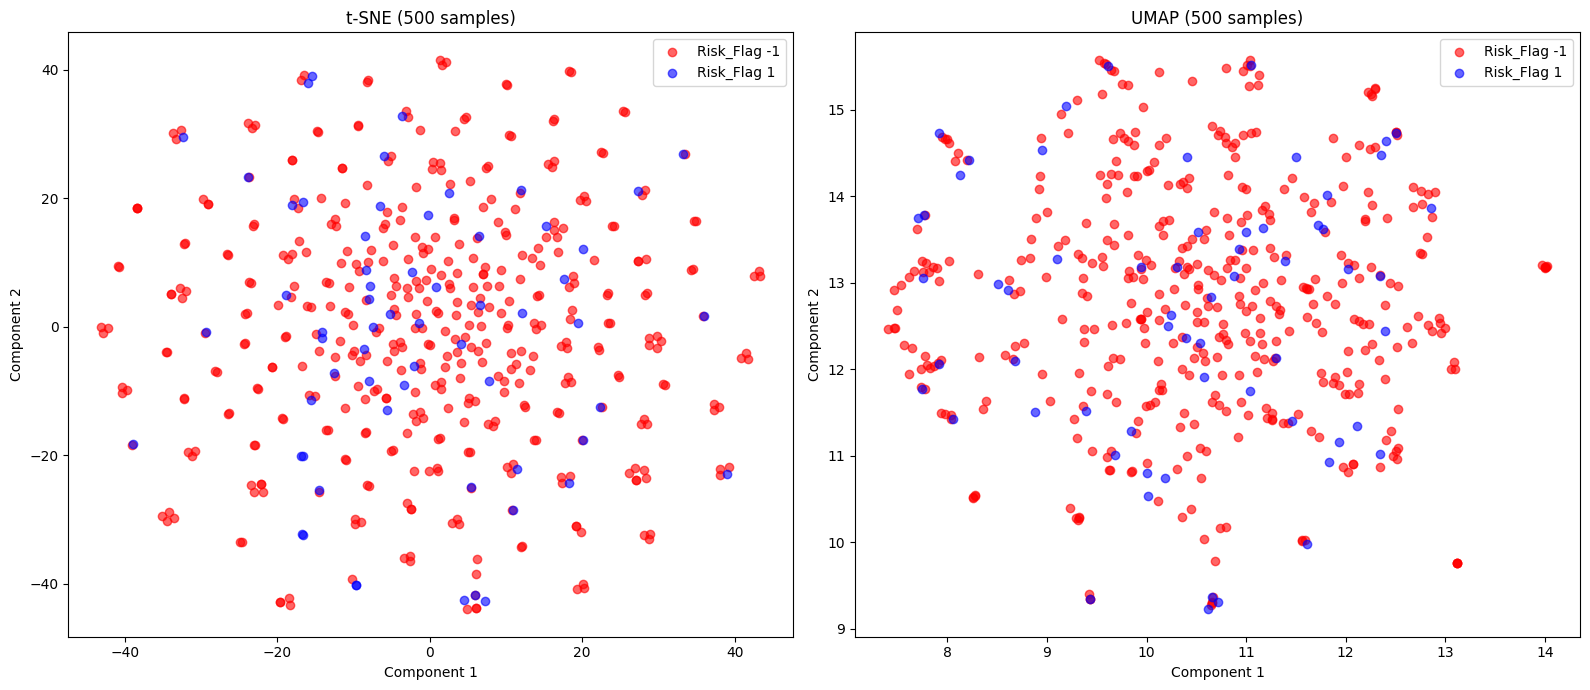

In [ ]:
# Subset of data
X_sample, _, y_sample, _ = train_test_split(
    X_scaled, y, train_size=500, stratify=y, random_state=9
)
y_sample_arr = y_sample.values

print("Running t-SNE on 500-sample subset...")
tsne = TSNE(n_components=2, random_state=9)
X_tsne = tsne.fit_transform(X_sample)

print("Running UMAP on 500-sample subset...")
umap_model = umap.UMAP(n_components=2, random_state=9)
X_umap = umap_model.fit_transform(X_sample)

# Plot the t-SNE and UMAP results
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].scatter(X_tsne[y_sample_arr == -1, 0], X_tsne[y_sample_arr == -1, 1],
                c='red', label='Risk_Flag -1', alpha=0.6)
axes[0].scatter(X_tsne[y_sample_arr == 1, 0], X_tsne[y_sample_arr == 1, 1],
                c='blue', label='Risk_Flag 1', alpha=0.6)
axes[0].set_title("t-SNE (500 samples)")
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].legend()

axes[1].scatter(X_umap[y_sample_arr == -1, 0], X_umap[y_sample_arr == -1, 1],
                c='red', label='Risk_Flag -1', alpha=0.6)
axes[1].scatter(X_umap[y_sample_arr == 1, 0], X_umap[y_sample_arr == 1, 1],
                c='blue', label='Risk_Flag 1', alpha=0.6)
axes[1].set_title("UMAP (500 samples)")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")
axes[1].legend()

plt.tight_layout()
plt.show()

### Use ADASYN with t-SNE and UMAP


Running ADASYN on 500-sample subset...
Running t-SNE on ADASYN-resampled subset...
Running UMAP on ADASYN-resampled subset...


c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\codyb\.vscode\Py\COMP7970-Homework\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


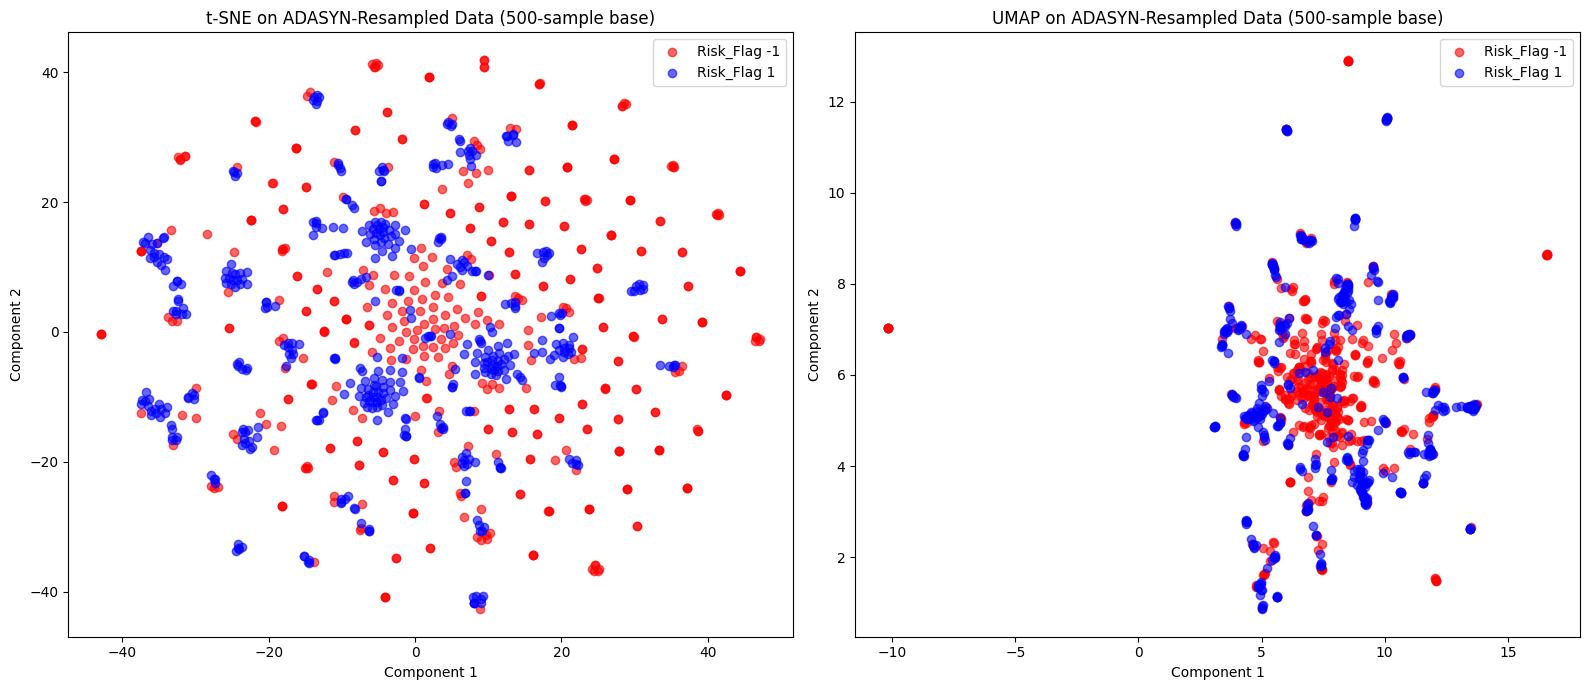

In [ ]:
print("\nRunning ADASYN on 500-sample subset...")
adasyn = ADASYN(random_state=9)
X_sample_adasyn, y_sample_adasyn = adasyn.fit_resample(X_sample, y_sample)

y_adasyn_arr = y_sample_adasyn.values

print("Running t-SNE on ADASYN-resampled subset...")
tsne_adasyn = TSNE(n_components=2, random_state=9)
X_tsne_adasyn = tsne_adasyn.fit_transform(X_sample_adasyn)

print("Running UMAP on ADASYN-resampled subset...")
umap_adasyn = umap.UMAP(n_components=2, random_state=9)
X_umap_adasyn = umap_adasyn.fit_transform(X_sample_adasyn)

# Plot ADASYN results for t-SNE and UMAP
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].scatter(X_tsne_adasyn[y_adasyn_arr == -1, 0], X_tsne_adasyn[y_adasyn_arr == -1, 1],
                c='red', label='Risk_Flag -1', alpha=0.6)
axes[0].scatter(X_tsne_adasyn[y_adasyn_arr == 1, 0], X_tsne_adasyn[y_adasyn_arr == 1, 1],
                c='blue', label='Risk_Flag 1', alpha=0.6)
axes[0].set_title("t-SNE on ADASYN-Resampled Data (500-sample base)")
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")
axes[0].legend()

axes[1].scatter(X_umap_adasyn[y_adasyn_arr == -1, 0], X_umap_adasyn[y_adasyn_arr == -1, 1],
                c='red', label='Risk_Flag -1', alpha=0.6)
axes[1].scatter(X_umap_adasyn[y_adasyn_arr == 1, 0], X_umap_adasyn[y_adasyn_arr == 1, 1],
                c='blue', label='Risk_Flag 1', alpha=0.6)
axes[1].set_title("UMAP on ADASYN-Resampled Data (500-sample base)")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")
axes[1].legend()

plt.tight_layout()
plt.show()